In [ ]:
# a = []
# while(1):
#     a.append('1')

In [ ]:
!pip install mycolorpy

In [ ]:
!apt-get install exiftool
!pip install git+https://github.com/detecttechnologies/thermal_base.git@main

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
libimage-exiftool-perl is already the newest version (10.80-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning https://github.com/detecttechnologies/thermal_base.git (to revision main) to /tmp/pip-req-build-kwd0nbz6
  Running command git clone -q https://github.com/detecttechnologies/thermal_base.git /tmp/pip-req-build-kwd0nbz6


In [ ]:
!pip install rasterio

In [ ]:
# from lsat_imgread import import_image
# from dji_imgread import read_image
import matplotlib.pyplot as plt
import numpy as np
from mycolorpy import colorlist as mcp
import rasterio as rio
import numpy.ma as ma
import imutils
from thermal_base import ThermalImage

In [ ]:
def normalize_data(data):
    # normalizes the data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [ ]:
def read_image(image_path):
    """This function transforms a DJI Mavic 2 Enterprise Due drone image into a numpy array.
    input: JPG thermal image path.
    output: temperature numpy array."""

    # Uses the library thermal_base to process the DJI image.
    # (https://github.com/detecttechnologies/thermal_base)

    image = ThermalImage(image_path=image_path, camera_manufacturer="dji")

    thermal_np = image.thermal_np           # The temperature matrix as a np array
    raw_sensor_np = image.raw_sensor_np     # The raw thermal sensor excitation values # as a np array
    meta = image.meta                     # Image metadata

    # return normalize_data(raw_sensor_np), meta
    return thermal_np, meta

In [ ]:
def rotate_image(img):
    # rotates image
    return imutils.rotate(img, angle=12.5)

In [ ]:
def import_image(image_path, band):
    with rio.open(image_path) as img:
        image = img.read(1)
        # image_array = np.array(image, dtype="float64")
        # rotating image
        image_array = rotate_image(image)

    # converting temperatures from Kelvin to Celcius
    if band == 10:
        L = 3.3420E-04 * image_array + 0.10000
        image_array = (1321.0789 / np.log((774.8853 / L) + 1)) - 273.15
    elif band == 11:
        image_array = (1201.1442 / np.log((480.8883 / (3.3420E-04 * image_array + 0.10000)) + 1))

    # image_array = normalize_data(image_array)

    return ma.masked_less_equal(image_array, 0)

In [ ]:
def compare_images(landsat, drone, dates):
    plt.figure(figsize=(16,dates*4))
    keys = list(landsat.keys())
    for i in range(dates):
      plt.subplot(dates, 2, i*2 +1)
      plt.xlabel("Temperature (˚C)")
      plt.ylabel("Number of of Pixels")
      plt.title("Landsat 8 - " + str(keys[i]))
      plt.hist(landsat[keys[i]], color=mcp.gen_color(cmap="Blues", n=landsat[keys[i]].shape[1]))
      # plt.legend(loc='upper right')
      plt.subplot(dates, 2, i*2 +2)
      plt.xlabel("Temperature (˚C)")
      plt.title("DJI Drone - " + str(keys[i]))
      for j in range(len(drone[keys[i]])):
        plt.hist(drone[keys[i]][j], color=mcp.gen_color(cmap="Greens", n=drone[keys[i]][i].shape[1]))
    # plt.legend(loc='upper right')
    plt.show()

In [ ]:
def read_dji_images(path, range_start, range_end, missing_images):
  all_temp = []
  for i in range(range_start, range_end, 2):
    image_path = str(path)+ str(i) +".JPG"
    if i in missing_images:
      pass
    else:
      image, meta = read_image(image_path)
      all_temp.append(image)
  return all_temp
    
    
    
    # for r in range(image.shape[0]):
    #   for c in range(image.shape[1]):
    #     temp = image[r][c]
    #     if temp in all_temp:
    #       all_temp[temp] = all_temp[temp] + 1
    #     else:
    #       all_temp[temp] = 1

In [ ]:
dji_images = {}
landsat_images = {}

### Data collected on 12/14/2021

In [ ]:
# Reading drone images
dec_14_path = "/content/drive/MyDrive/Grad/Research/Data/1214/thermal/DJI_0"
dec_14_missing_images = [408, 410, 412, 414]
dec_14_start = 354
dec_14_end = 473

dec_14_temperatures = read_dji_images(dec_14_path, dec_14_start, dec_14_end, dec_14_missing_images)

In [ ]:
# Reading landsat image
dec_14_landsat_image = import_image("/content/drive/MyDrive/Grad/Research/Data/Landsat/L08_1214_B10.TIF", 10)

In [ ]:
dji_images["12-14"] = dec_14_temperatures
landsat_images["12-14"] = dec_14_landsat_image

In [ ]:
dji_images["12-14"][0].shape[1]

640

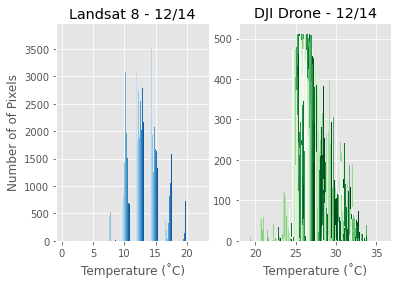

In [ ]:
plt.subplot(1, 2, 1)
plt.xlabel("Temperature (˚C)")
plt.ylabel("Number of of Pixels")
plt.title("Landsat 8 - 12/14")
plt.hist(landsat_images["12-14"], color=mcp.gen_color(cmap="Blues", n=landsat_images["12-14"].shape[1]))

plt.subplot(1, 2, 2)
plt.xlabel("Temperature (˚C)")
plt.title("DJI Drone - 12/14")
for j in range(len(dji_images["12-14"])):
  plt.hist(dji_images["12-14"][j], color=mcp.gen_color(cmap="Greens", n=dji_images["12-14"][0].shape[1]))

### Data collected on 03/04/2022

In [ ]:
# Reading drone images
mar_04_path = "/content/drive/MyDrive/Grad/Research/Data/0304/thermal/DJI_0"
mar_04_missing_images = [408, 410, 412, 414]
mar_04_start = 478
mar_04_end = 597

mar_04_temperatures = read_dji_images(mar_04_path, mar_04_start, mar_04_end, mar_04_missing_images)

In [ ]:
mar_04_landsat_image = import_image("/content/drive/MyDrive/Grad/Research/Data/Landsat/L8_0304_B10.TIF", 10)

In [ ]:
dji_images["03-04"] = mar_04_temperatures
landsat_images["03-04"] = mar_04_landsat_image

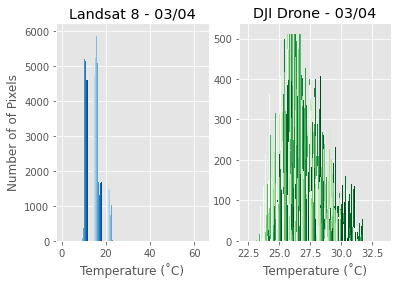

In [ ]:
plt.subplot(1, 2, 1)
plt.xlabel("Temperature (˚C)")
plt.ylabel("Number of of Pixels")
plt.title("Landsat 8 - 03/04")
plt.hist(landsat_images["03-04"], color=mcp.gen_color(cmap="Blues", n=landsat_images["03-04"].shape[1]))

plt.subplot(1, 2, 2)
plt.xlabel("Temperature (˚C)")
plt.title("DJI Drone - 03/04")
for j in range(len(dji_images["03-04"])):
  plt.hist(dji_images["03-04"][j], color=mcp.gen_color(cmap="Greens", n=dji_images["03-04"][0].shape[1]))

In [ ]:
# Comparing images' histograms
# compare_images(landsat_images, dji_images,2)

In [ ]:
# plt.figure(figsize=(16,2*4))
# keys = list(landsat_images.keys())
# # for i in range(2):
# i=0
# plt.subplot(2, 2, i*2 +1)
# plt.xlabel("Temperature (˚C)")
# plt.ylabel("Number of of Pixels")
# plt.title("Landsat 8 - " + str(keys[i]))
# plt.hist(landsat_images[keys[i]], color=mcp.gen_color(cmap="Blues", n=landsat_images[keys[i]].shape[1]))

# plt.subplot(2, 2, i*2 +2)
# plt.xlabel("Temperature (˚C)")
# plt.title("DJI Drone - " + str(keys[i]))
# for j in range(len(dji_images[keys[i]])):
#   plt.hist(dji_images[keys[i]][j], color=mcp.gen_color(cmap="Greens", n=dji_images[keys[i]][i].shape[1]))
# i=1
# plt.subplot(2, 2, i*2 +1)
# plt.xlabel("Temperature (˚C)")
# plt.ylabel("Number of of Pixels")
# plt.title("Landsat 8 - " + str(keys[i]))
# plt.hist(landsat_images[keys[i]], color=mcp.gen_color(cmap="Blues", n=landsat_images[keys[i]].shape[1]))

# plt.subplot(2, 2, i*2 +2)
# plt.xlabel("Temperature (˚C)")
# plt.title("DJI Drone - " + str(keys[i]))
# for j in range(len(dji_images[keys[i]])):
#   plt.hist(dji_images[keys[i]][j], color=mcp.gen_color(cmap="Greens", n=dji_images[keys[i]][i].shape[1]))

# plt.show()

In [ ]:
# landsat_image.shape

In [ ]:
# dji_image.shape

In [ ]:
# # Trying to obtaing a correlation between the images
# from scipy.stats.stats import pearsonr
# import pandas as pd

In [ ]:
# satellite_image = pd.DataFrame(landsat_image)

# def get_correlation(vals, row):
#   return pearsonr(vals, dji_image[row])
# for row_l in range(landsat_image.shape[1]):
#   for row in range(dji_image.shape[0]):
#     range = satellite_image[row_l].rolling(window=dji_image.shape[1]).to_numpy()
#     print(get_correlation(range, row))

In [ ]:
# # Reading both images
# landsat_image_2 = import_image("/content/drive/MyDrive/Grad/Research/Github-Colab/Cofc-Research/img/LC08_L1TP_016037_20220304_20220305_02_RT_B10.TIF", 10)
# dji_image_2, dji_meta_2 = read_image("/content/drive/MyDrive/Grad/Research/Github-Colab/Cofc-Research/img/DJI_0518.JPG")

In [ ]:
# # Comparing images' histograms
# compare_images(landsat_image_2, dji_image_2)

# ARD

In [ ]:
# def import_ar_image(image_path):
#     with rio.open(image_path) as img:
#         image = img.read(1)
#         # image_array = np.array(image, dtype="float64")
#         # rotating image
#         image_array = rotate_image(image)

#     # converting temperatures from Kelvin to Celcius
#     if band == 10:
#         L = 3.3420E-04 * image_array + 0.10000
#         image_array = (1321.0789 / np.log((774.8853 / L) + 1)) - 273.15
#     elif band == 11:
#         image_array = (1201.1442 / np.log((480.8883 / (3.3420E-04 * image_array + 0.10000)) + 1))

#     # image_array = normalize_data(image_array)

#     return ma.masked_less_equal(image_array, 0)